# Ayudantía 11

## DFT for Poisson problem

Consideramos el problema:

$$\begin{align*}
-\Delta u &= f(x,y) & x\in\Omega = (0, 1)^2\\
u &= 0 & x\in\partial\Omega 
\end{align*}$$

Queremos resolverlo usando el método de Discrete Fourier Transform

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.fft import ifft, ifft2, fft, fft2

In [2]:
pi, cos, sen = np.pi, np.cos, np.sin

### Motivación, resolver usando descomposición de valores propios:

Recordamos como resolver este problema usando la matriz tridiagonal de tamaño $N$. Este es buscando una matriz $V$ tal que

$$VT_N + T_NV = h^2F$$

donde $T_N = \text{tridiag}(-1, 2, -1)$ de $N\times N$ y $F_{ij} = f(x_i, y_j)$.

Usando la descomposición en valores propios de $T_N$, este proceso es de $O(n^{3/2}) = O(N^3)$ operaciones! Veamos un ejemplo de como sería resolver este sistema mediante este procedimiento con una matriz chica.

Si $T_N = Z\Lambda Z^T$ (por simetría), entonces:

$$\lambda_j = 2\left(1 - \cos\left(\frac{\pi j}{N+1}\right)\right),\quad j=1,\dots,N$$

Y si $Z = [z_1, \dots, z_N]$, entonces:

$$z_{j}(k) = \sqrt{\frac{2}{N+1}}\sin\left(\frac{jk\pi}{N+1}\right),\quad j, k = 1,\dots,N$$

In [3]:
N = 10
Lambda = np.diag([2*(1 - cos(pi*j/(N + 1))) for j in range(1, N+1)])
Z = np.zeros((N, N), dtype=float)

for j in range(1, N+1):
    Z[:,j-1] = np.array([np.sqrt(2/(N+1))*sen(j*k*pi/(N+1)) for k in range(1, N+1)])

In [4]:
np.round(Z@Lambda@Z.T)

array([[ 2., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.],
       [-1.,  2., -1., -0.,  0., -0., -0., -0., -0.,  0.],
       [ 0., -1.,  2., -1.,  0., -0.,  0., -0., -0., -0.],
       [ 0., -0., -1.,  2., -1., -0., -0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  2., -1., -0., -0., -0., -0.],
       [ 0., -0., -0., -0., -1.,  2., -1.,  0.,  0.,  0.],
       [ 0., -0.,  0., -0., -0., -1.,  2., -1., -0.,  0.],
       [ 0., -0., -0.,  0., -0.,  0., -1.,  2., -1.,  0.],
       [ 0., -0.,  0.,  0., -0.,  0., -0., -1.,  2., -1.],
       [-0.,  0., -0.,  0., -0.,  0.,  0.,  0., -1.,  2.]])

In [5]:
def solve_with_eigendecom(Lambda, Z, f):
    
    N = Lambda.shape[0]
    F = np.zeros((N, N), dtype=float)
    h = 1/(N+1)
    
    for i in range(1, N+1):
        xi = i*h
        for j in range(1, N+1):
            yj = j*h
            F[i-1, j-1] = f([xi, yj])
    
    Fprime = Z.T@F@Z
    Vprime = np.zeros((N, N), dtype=float)
    
    for i in range(1, N+1):
        for j in range(1, N+1):
            Vprime[i-1, j-1] = (h*h)*Fprime[i-1, j-1]/(Lambda[i-1, i-1] + Lambda[j-1, j-1])
    
    V = Z@Vprime@Z.T
    
    return V

In [6]:
V = solve_with_eigendecom(Lambda, Z, lambda x: sen(pi*x[0])*sen(pi*x[1]))

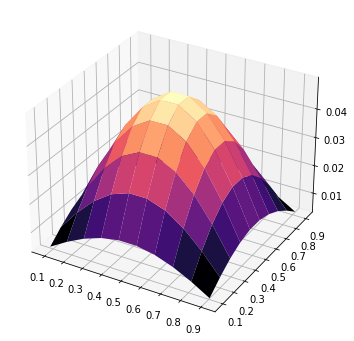

In [7]:
xx, yy = np.linspace(0, 1, num=N+2)[1:-1], np.linspace(0, 1, num=N+2)[1:-1]
X, Y = np.meshgrid(xx, yy)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(6, 6))

ax.plot_surface(X, Y, V, cmap="magma")
plt.show()

## DFT

Para un vector de tamaño $N$, su transformada de fourier discreta es el vector $y = \Phi x$, donde $\Phi$ es de $N\times N$ y tiene las siguientes entradas:

$$\Phi_{jk} = e^{-\frac{2\pi i}{N} jk}, \quad j,k=0,\dots,N-1$$

Veamos un ejemplo chico de como se vería esto para un vector cualquiera y como es $\Phi$

In [8]:
N = 5

In [9]:
Phi = np.zeros((N, N), dtype=complex)

for j in range(N):
    for k in range(N):
        Phi[j, k] = np.exp(-2*pi*1j*j*k/N)
        
x = np.ones(N)

In [10]:
print("Matrix Phi:\n", np.round(Phi, 2))

print("\nVector original:\n", x)

print("\nDFT del vector original:\n", np.round(Phi@x, 2))

Matrix Phi:
 [[ 1.  +0.j    1.  +0.j    1.  +0.j    1.  +0.j    1.  +0.j  ]
 [ 1.  +0.j    0.31-0.95j -0.81-0.59j -0.81+0.59j  0.31+0.95j]
 [ 1.  +0.j   -0.81-0.59j  0.31+0.95j  0.31-0.95j -0.81+0.59j]
 [ 1.  +0.j   -0.81+0.59j  0.31-0.95j  0.31+0.95j -0.81-0.59j]
 [ 1.  +0.j    0.31+0.95j -0.81+0.59j -0.81-0.59j  0.31-0.95j]]

Vector original:
 [1. 1. 1. 1. 1.]

DFT del vector original:
 [ 5.+0.j -0.-0.j  0.-0.j  0.-0.j  0.-0.j]


Antes, mostramos que podíamos resolver el sistema de Poisson multiplicando por la matriz $Z$. Si consideramos la matriz $\Phi$ de $2(N+1)\times 2(N+1)$, entonces sus entradas son:

$$\Phi_{j, k} = \exp\left(\frac{-\pi ijk}{N+1}\right) = \cos\left(\frac{\pi jk}{N+1}\right) - i\sin\left(\frac{\pi jk}{N+1}\right),\quad j,k=0,\dots,2N+1$$

Entonces, la matriz $Z$ de $N\times N$ corresponde a las entradas [1:N+1, 1:N+1] (en notación python), es decir, tal que $j, k=1,\dots,N$:

$$Z = -\sqrt{\frac{2}{N+1}}\text{Im}(\Phi)_{[1:N+1, 1:N+1]}$$

Así, vemos que si podemos multiplicar eficientemente por $\Phi$, entonces también lo podemos hacer por $Z$

### FFT

Vemos que si $a$ es un vector de $2N$, entonces

$$(\Phi a)_k = \sum_{j=0}^{2N-1}e^{-\frac{2\pi i}{2N}jk}a_j = \sum_{j=0}^{2N-1}(\omega^{k})^{j}a_j$$

Es decir, estamos evaluando en el polinomio siguiente con $\omega^k$:

$$a(x) = \sum_{j=0}^{2N-1}x^{j}a_j$$


Consideramos el polinomio:

$$a(x) = a_0 + a_1x + a_2x^2 + \dots + a_{N-1}x^{N-1}$$

Lo podemos dividir como:

$$a(x) = (a_0 + a_2x^2 + a_4x^4 + \dots) + x(a_1 + a_3x^2 + a_5x^4 + \dots)$$

$$a(x) = a_{\text{par}}(x^2) + xa_{\text{impar}}(x^2)$$

In [11]:
def permutation_matrix(N):
    
    P = np.eye(N)
    sort_mask_even = np.arange(0, N, 2)
    sort_mask_odd = np.arange(1, N, 2)
    
    sort_mask = np.append(sort_mask_even, sort_mask_odd)
    P[:,:] = P[:,sort_mask]
    return P


def FFT(a, N):
    """
    Asumimos N es de la forma 2^n para n natural
    Calcula la DFT de un vector de tamaño N
    """
    if N == 1:
        return a
    
    else:
        P = permutation_matrix(N)
        aP = a@P
        k = N//2
        
        a_even = aP[:k]
        a_odd = aP[k:]
        aprime_even = FFT(a_even, k)
        aprime_odd = FFT(a_odd, k)

        omega = np.exp(-2*1j*np.pi/N)
        w = np.array([omega**j for j in range(k)])
        aprime1 = aprime_even + w*aprime_odd #Pointwise multiplication
        aprime2 = aprime_even - w*aprime_odd #Pointwise multiplication
        return np.append(aprime1, aprime2)

In [12]:
N = 8
a = np.ones(N)
Phia = FFT(a, N)

In [13]:
print(np.round(Phia))

[8.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [15]:
print(ifft(Phia).real)

[1. 1. 1. 1. 1. 1. 1. 1.]


## Resolviendo el problema usando la DFT


Planteamos que la solución al problema $u$ tiene expansión de la forma:


$$u(x, y) = \sum_{j,k=-N/2}^{N/2} u_{jk}e^{2\pi i(jx+ky)}$$

Así, $-\Delta u$ se ve como sigue:

$$-\Delta u  (x,y) = \sum_{j,k=-N/2}^{N/2}4\pi^2(j^2+k^2) u_{jk}e^{2\pi i(jx+ky)} = \sum_{j,k=-N/2}^{N/2} f_{jk}e^{2\pi i(jx+ky)} = f(x,y)$$

Aquí, $f_{jk}$ son los coeficientes de la serie de fourier de $f$. Entonces:

$$u_{jk} = \frac{1}{4\pi^2(j^2+k^2)}f_{jk}$$

### 1D

In [16]:
f = lambda x: sen(2*pi*x)
u = lambda x: sen(2*pi*x)/(4*pi**2)

In [17]:
def Base1D(x, n):
    """
    n-ésima base de L^2((0, 1)) 
    """
    return np.exp(2*pi*1j*n*x)

def FFT1D(f, N, uexact, TRY=False):
    
    #Condición periódica, no necesitamos el último
    x = np.linspace(0, 1, num=N, endpoint=False)
    
    #RHS vector
    F = f(x)
    
    # DFT coefficients
    fhat = fft(F)/F.size # no me queda claro pq hay que dividir por F.size
    
    # Fourier series coefficient transformation
    for n in range(-N//2+1, N//2+1):
        if n != 0:
            fhat[n] = fhat[n]/((2*pi*n)**2)
    
    usol = lambda x: sum(fhat[n]*Base1D(x, n) for n in range(-N//2+1, N//2+1))
    
    if TRY:
        
        ucoef = ifft(fhat)*fhat.size # no me queda claro por que
        ucoef = np.append(ucoef, ucoef[0])
        y = np.append(x, [1])
        t = np.linspace(0, 1)
        plt.figure(figsize=(8, 8))
        plt.plot(y, ucoef.real, "r+-", label=f"{N} coef with IFFT")
        plt.plot(t, usol(t).real, "k--", label=f"{N}-term Fourier Series")
        plt.plot(t, uexact(t), "b", label=f"Exact Sol", alpha=0.5)
        plt.title(f"Distintas aproximaciones de solución exacta")
        plt.legend(loc="best")
        plt.show()
        
        return usol, ucoef
        
    return usol

def ErrorL2(uexact, uFourier, xmin=0, xmax=1):
    fun = lambda x: abs(uexact(x) - uFourier(x))**2
    err = np.sqrt(quad(fun, xmin, xmax)[0])
    return err

def ratio(Errlist, Nlist):
    m = len(Nlist)
    r = np.zeros(m) 
    for j in range(m-1):
        r[j+1] = np.log(Errlist[j+1]/Errlist[j])/ np.log(Nlist[j]/Nlist[j+1])
    return r

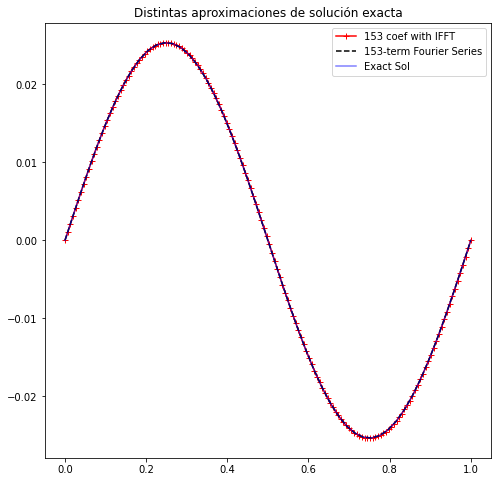

In [20]:
usol, ucoef = FFT1D(f, 153, u, TRY=True)

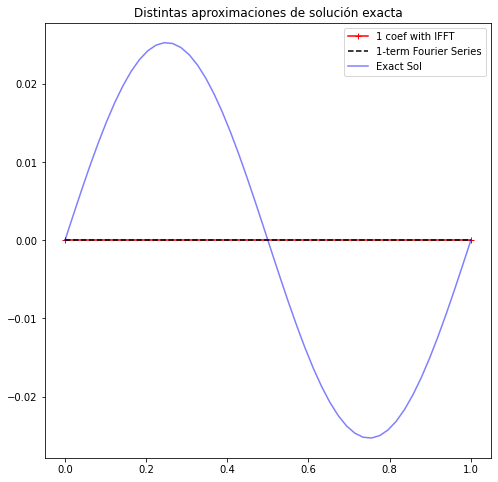

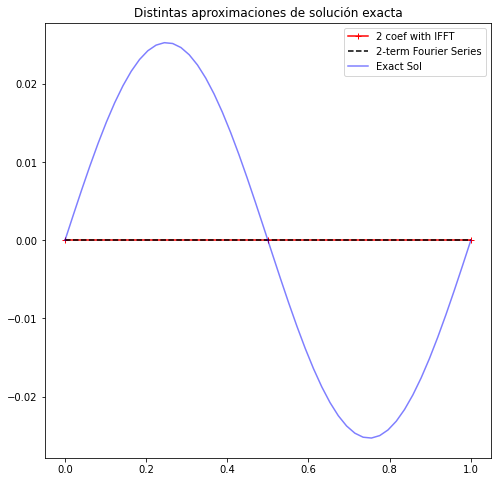

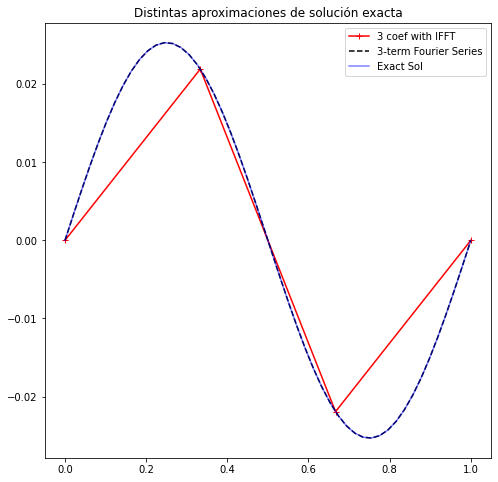

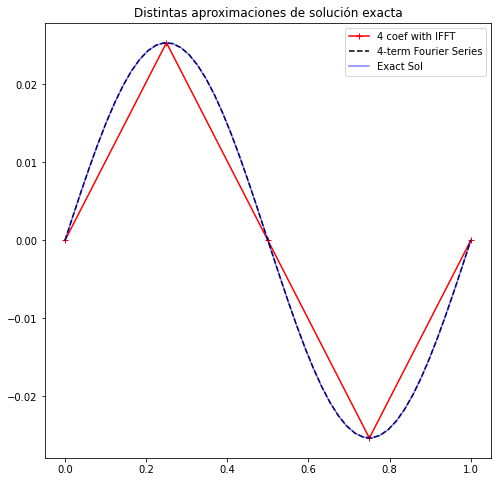

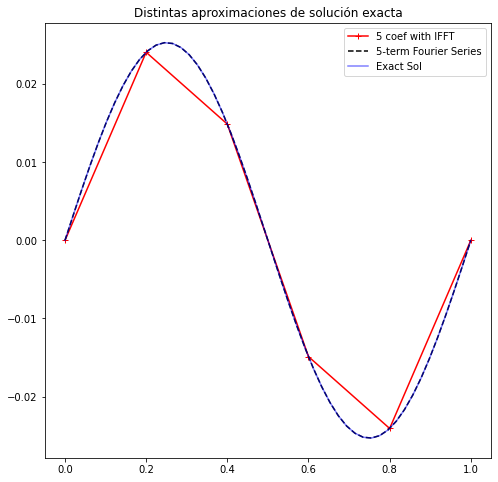

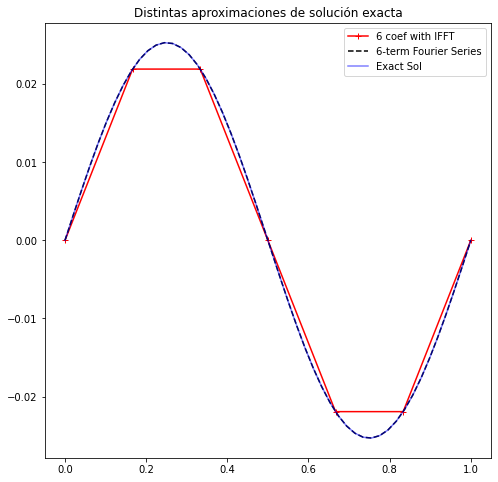

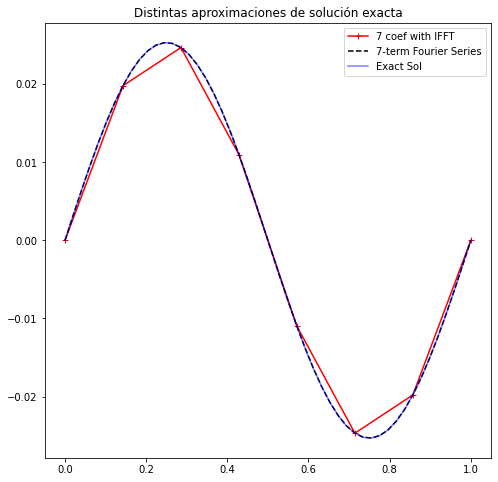

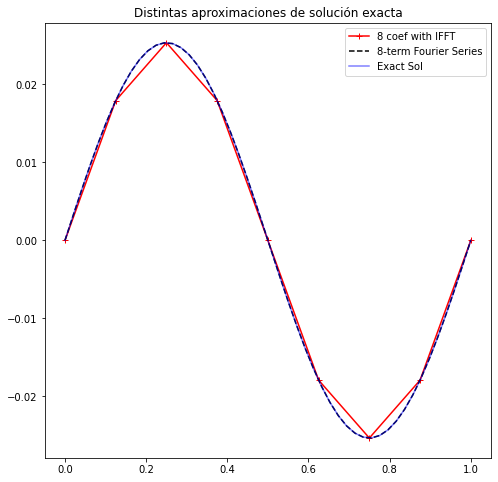

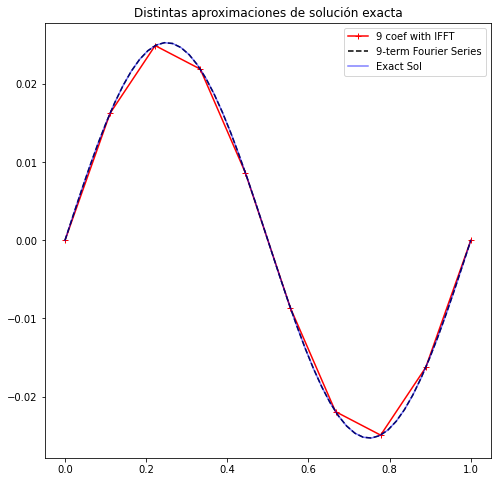

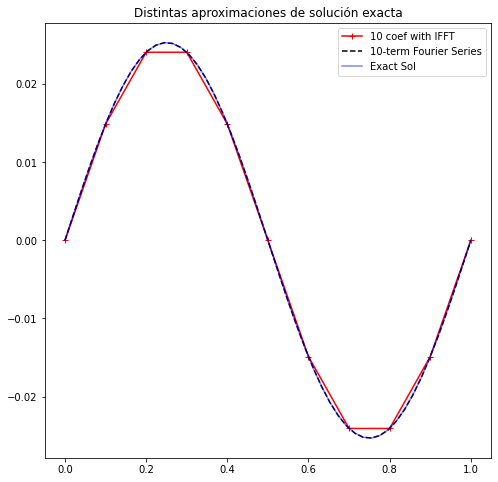

[  0.          -0.          79.97744922   5.45723378  -1.69277323
   4.63590428  -3.19281004  16.42066637 -16.35281235   0.64806917]


In [21]:
Nlist = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
err_list = []
for n in Nlist:
    usol_n, ucoef_n = FFT1D(f, n, u, TRY=True)
    err_list.append(ErrorL2(u, usol_n))

r = ratio(err_list, Nlist)
print(r)

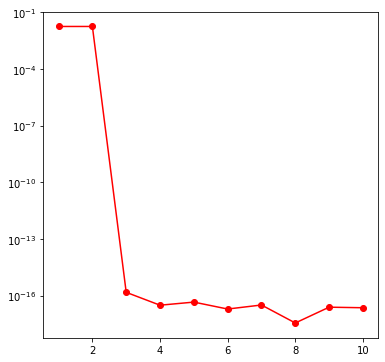

[0.01791122400783613, 0.01791122400783613, 1.4784121944471088e-16, 3.075924295442303e-17, 4.487684509912014e-17, 1.9272836649358264e-17, 3.1527825799977066e-17, 3.519067593624037e-18, 2.414989293627728e-17, 2.2555953500407557e-17]


In [23]:
plt.figure(figsize=(6, 6))
plt.plot(Nlist, err_list, "ro-")
plt.yscale("log")
plt.show()

print(err_list)

### 2D

In [26]:
f = lambda x: sen(2*pi*x[0])*sen(2*pi*x[1])
u = lambda x: sen(2*pi*x[0])*sen(2*pi*x[1])/(8*pi*pi)

In [42]:
def Base2D(x, n, m):
    """
    Base de L^2((0, 1)^2) 
    """
    return np.exp(2*pi*1j*(n*x[0] + m*x[1]))


def FFT2D(f, N, u, TRY=False):
    
    xx = np.linspace(0, 1, num=N, endpoint=False)
    yy = np.linspace(0, 1, num=N, endpoint=False)
    X, Y = np.meshgrid(xx, yy)
    
    # RHS vector
    F = f([X, Y])
    
    # RHS vector
    fhat = fft2(F)/F.size
    
    for n in range(-N//2 + 1, N//2+1):
        for m in range(-N//2 + 1, N//2+1):
            if n != 0 or m!=0:
                fhat[n, m] = fhat[n, m]/(4*pi*pi*(n**2 + m**2))
                
    
    usol = lambda x: sum(fhat[n, m]*Base2D(x, n, m) for n in range(-N//2+1, N//2+1) for m in range(-N//2+1, N//2+1))
    
    if TRY:
        
        ucoef = ifft2(fhat)*fhat.size
        
        U = np.zeros((N+1, N+1), dtype=complex)
        
        for i in range(ucoef.shape[0]):
            U[i,:] = np.append(ucoef[i,:], ucoef[i,0])
        
        for j in range(ucoef.shape[1]):
            U[:,j] = np.append(ucoef[:,j], ucoef[0,j])
        
        xx = np.linspace(0, 1, num=N+1)
        yy = np.linspace(0, 1, num=N+1)
        
        X, Y = np.meshgrid(xx, yy)
        
        xx = np.linspace(0, 1)
        yy = np.linspace(0, 1)
        X1, Y1 = np.meshgrid(xx, yy)


        fig, ax = plt.subplots(ncols=3, subplot_kw={"projection": "3d"}, figsize=(18, 6))
        
        ax[0].plot_surface(X, Y, U.real, cmap="magma")

        ax[1].plot_surface(X1, Y1, usol([X1, Y1]).real, cmap="magma")
        
        ax[2].plot_surface(X1, Y1, u([X1, Y1]).real, cmap="magma")
        
        ax[0].set_title(f"${N}^2$ coeficients")
        ax[1].set_title(f"${N}^2$-term Fourier Series")
        ax[2].set_title("Real function")
        
        plt.show()
        
        return usol, U
    
    return usol

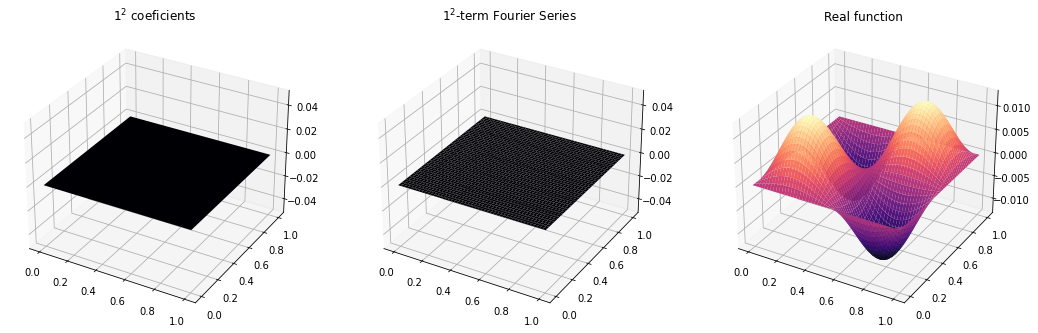

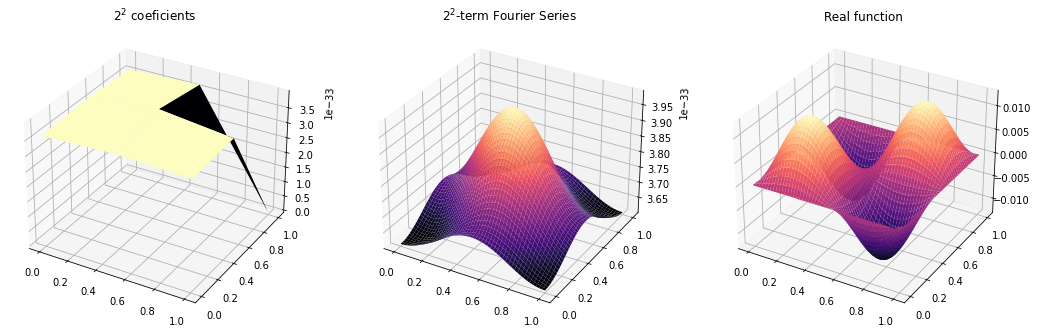

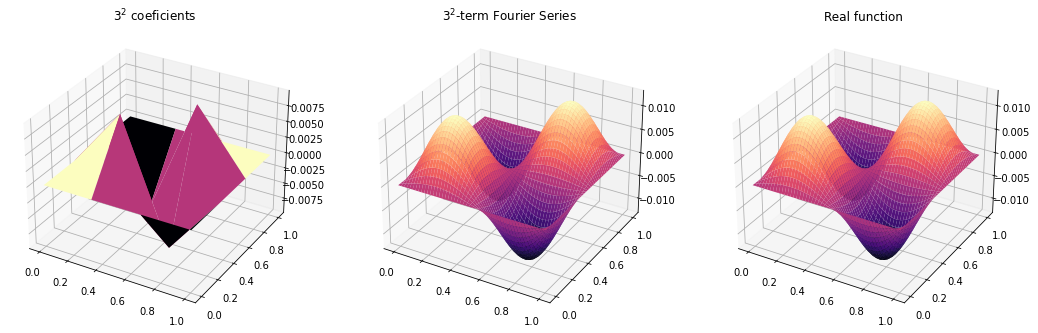

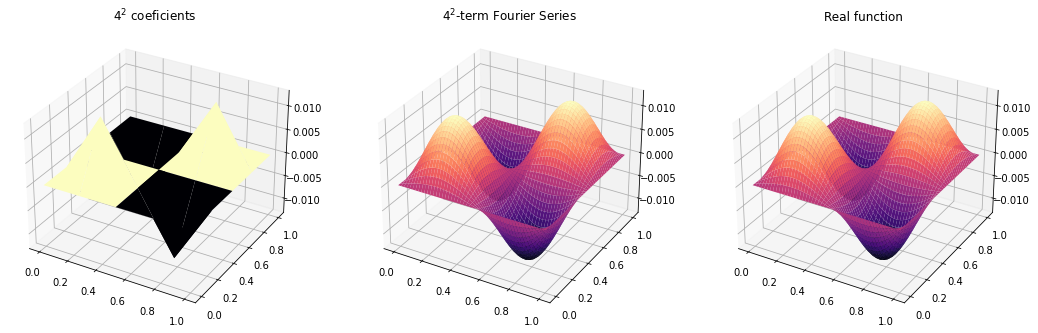

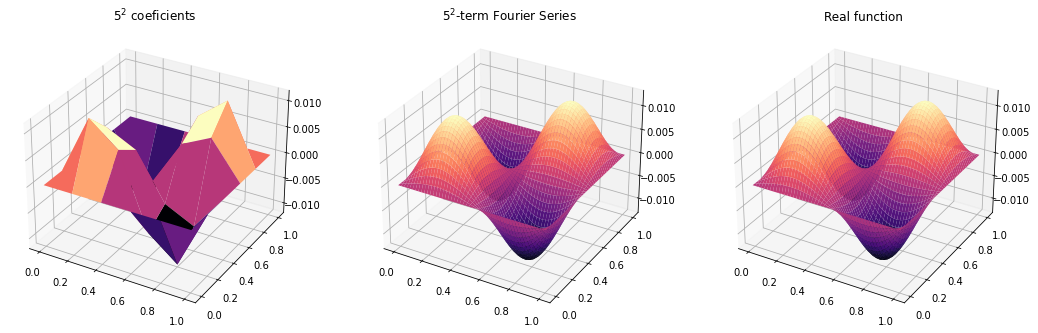

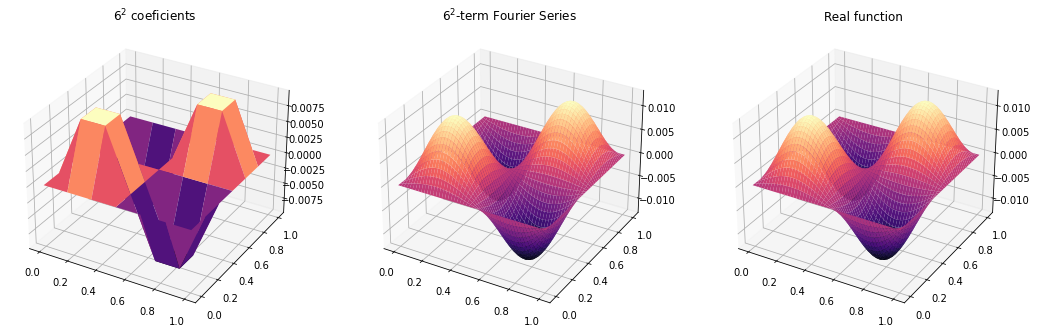

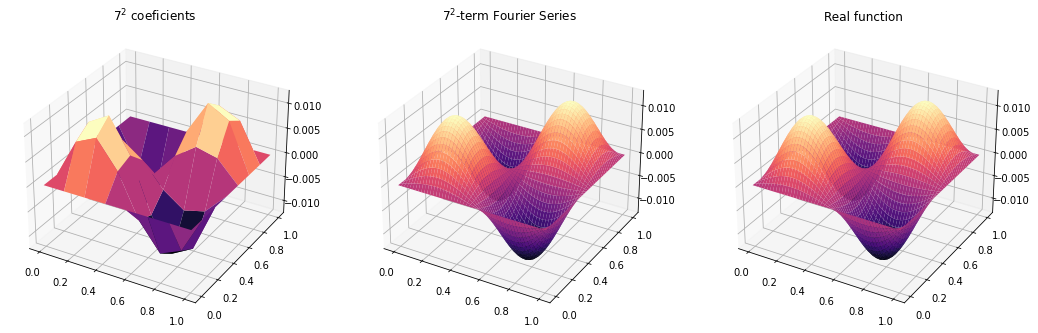

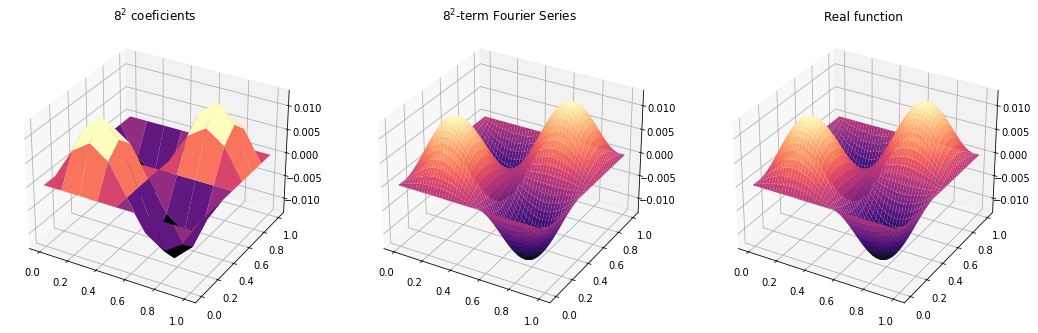

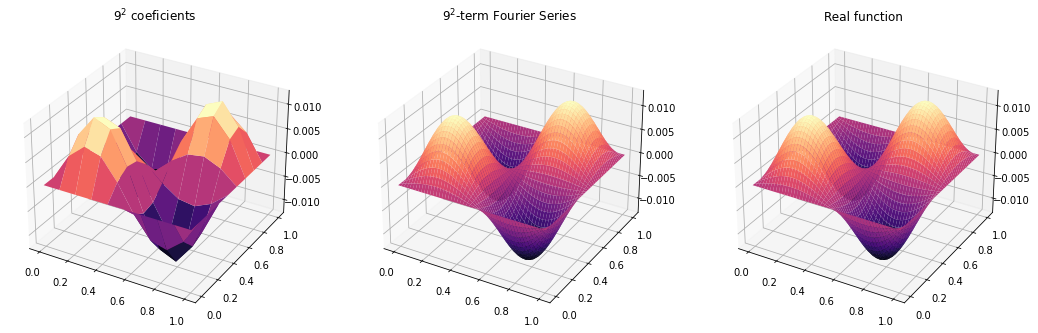

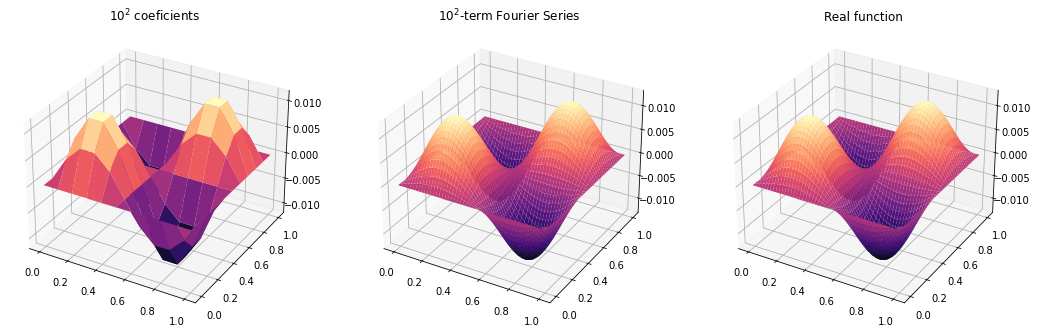

In [28]:
Nlist = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for n in Nlist:
    usol, U = FFT2D(f, n, u, TRY=True)

## Extra! Producto Kronecker

Se define:

$$A\otimes B = 
\begin{bmatrix}
a_{11}B&\dots&a_{1n}B\\
\vdots&\ddots&\vdots\\
a_{m1}B&\dots&a_{mn}B
\end{bmatrix}$$

Si $A$ de $m\times n$, $B$ de $p\times q$, entonces $A\otimes B$ de $mp\times nq$